In [4]:
!pip install ultralytics pillow lxml -q

import os
import random
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:

ARCHIVE_DIR = "archive"  
IMAGES_DIR = os.path.join(ARCHIVE_DIR, "images")
ANNOT_DIR = os.path.join(ARCHIVE_DIR, "annotations")
LABELS_DIR = os.path.join(ARCHIVE_DIR, "labels")
os.makedirs(LABELS_DIR, exist_ok=True)

CLASSES = ["with_mask", "without_mask", "mask_weared_incorrect"]

def voc_to_yolo():
    for xml_file in os.listdir(ANNOT_DIR):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(ANNOT_DIR, xml_file))
        root = tree.getroot()

        img_file = root.find("filename").text
        img_path = os.path.join(IMAGES_DIR, img_file)
        if not os.path.exists(img_path):
            continue

        img = Image.open(img_path)
        w, h = img.size

        label_path = os.path.join(LABELS_DIR, xml_file.replace(".xml", ".txt"))
        with open(label_path, "w") as f:
            for obj in root.findall("object"):
                cls = obj.find("name").text
                if cls not in CLASSES:
                    continue
                cls_id = CLASSES.index(cls)
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                # Convert to YOLO format
                x_center = (xmin + xmax) / 2 / w
                y_center = (ymin + ymax) / 2 / h
                bw = (xmax - xmin) / w
                bh = (ymax - ymin) / h

                f.write(f"{cls_id} {x_center} {y_center} {bw} {bh}\n")

voc_to_yolo()
print("✅ XML annotations converted to YOLO format.")


✅ XML annotations converted to YOLO format.


In [7]:

OUT_DIR = "dataset"
for subset in ["train", "val"]:
    for sub in ["images", "labels"]:
        os.makedirs(os.path.join(OUT_DIR, subset, sub), exist_ok=True)

images = [f for f in os.listdir(IMAGES_DIR) if f.endswith((".jpg", ".png"))]
random.shuffle(images)
split = int(0.8 * len(images))
train_imgs, val_imgs = images[:split], images[split:]

def copy_files(imgs, subset):
    for img in imgs:
        shutil.copy(os.path.join(IMAGES_DIR, img), os.path.join(OUT_DIR, subset, "images", img))
        label = img.rsplit(".", 1)[0] + ".txt"
        src_label = os.path.join(LABELS_DIR, label)
        dst_label = os.path.join(OUT_DIR, subset, "labels", label)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

copy_files(train_imgs, "train")
copy_files(val_imgs, "val")
print(f"Dataset split: {len(train_imgs)} train, {len(val_imgs)} val.")


Dataset split: 682 train, 171 val.


In [8]:

data_yaml = "mask_data.yaml"
with open(data_yaml, "w") as f:
    f.write(f"""
train: {os.path.abspath(OUT_DIR)}/train/images
val: {os.path.abspath(OUT_DIR)}/val/images
nc: 3
names: {CLASSES}
""")
print("data.yaml created.")

data.yaml created.


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  

results = model.train(
    data=data_yaml,
    epochs=30,       
    imgsz=416
)

print("Training complete. Best weights saved in runs/detect/train/weights/best.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/jiveshkarthik/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.204 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M1 Max)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=mask_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, kera

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       1/30         0G      1.816      2.529      1.272        138        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:031.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.4s.9s
                   all        302       1414      0.852      0.109      0.286      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30         0G       1.38      1.306      1.037        133        416: 94% ━━━━━━━━━━━─ 48/51 0.4it/s 1:59<7.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       2/30         0G      1.383      1.303      1.036        134        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:021.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.7s.0s
                   all        302       1414      0.929      0.304      0.465      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30         0G      1.343      1.171      1.029        154        416: 20% ━━────────── 10/51 0.4it/s 26.6s<1:43

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       3/30         0G      1.324      1.135      1.022        103        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:031.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.9s.0s
                   all        302       1414      0.579      0.483      0.532      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30         0G      1.298      1.077      1.025         92        416: 4% ──────────── 2/51 0.2it/s 7.3s<3:50

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       4/30         0G        1.3      1.044      1.013         69        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:031.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.9s.0s
                   all        302       1414      0.586      0.547      0.559      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30         0G      1.286     0.9782      1.001        141        416: 69% ━━━━━━━━──── 35/51 0.4it/s 1:28<39.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       5/30         0G      1.274     0.9788     0.9985         89        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:041.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 17.2s.1s
                   all        302       1414      0.681      0.545      0.574      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30         0G      1.176     0.8817     0.9947        132        416: 8% ╸─────────── 4/51 0.3it/s 12.5s<2:34

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       6/30         0G      1.247      0.934      0.989         97        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:041.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.5s.9s
                   all        302       1414      0.627      0.542      0.609      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30         0G      1.227     0.9296      1.014        115        416: 10% ━─────────── 5/51 0.3it/s 14.4s<2:13

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       7/30         0G      1.225     0.9133     0.9837         79        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:011.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.5s.9s
                   all        302       1414      0.895      0.564      0.673      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30         0G      1.219     0.8962      1.008        107        416: 20% ━━────────── 10/51 0.4it/s 26.5s<1:42

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       8/30         0G      1.184     0.8745     0.9726         85        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:021.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.3s.9s
                   all        302       1414       0.76      0.605       0.68      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30         0G      1.201     0.8361     0.9707        154        416: 86% ━━━━━━━━━━── 44/51 0.4it/s 1:48<16.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


       9/30         0G        1.2     0.8358     0.9708         51        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:011.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.5s.0s
                   all        302       1414       0.68      0.587      0.651      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30         0G      1.176     0.8094     0.9582        129        416: 63% ━━━━━━━╸──── 32/51 0.4it/s 1:20<46.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      10/30         0G      1.173     0.8071     0.9596        123        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:031.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.7s.0s
                   all        302       1414      0.854        0.6      0.717      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30         0G      1.187     0.8182      0.965        111        416: 20% ━━────────── 10/51 0.4it/s 26.6s<1:42

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      11/30         0G      1.159     0.7665     0.9535        101        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:021.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.6s.9s
                   all        302       1414      0.728      0.629      0.704      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30         0G      1.143     0.7725      0.959         80        416: 51% ━━━━━━────── 26/51 0.3it/s 1:18<1:203

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      12/30         0G      1.151     0.7659      0.961         81        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:221.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.6s.9s
                   all        302       1414      0.743      0.697      0.732      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30         0G      1.146     0.7342     0.9386        107        416: 45% ━━━━━─────── 23/51 0.4it/s 58.0s<1:08

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      13/30         0G      1.121     0.7248     0.9435         78        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:021.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.8s.0s
                   all        302       1414      0.902      0.685      0.779      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30         0G      1.116     0.7193     0.9413        165        416: 43% ━━━━━─────── 22/51 0.4it/s 55.7s<1:11

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      14/30         0G      1.116     0.7209     0.9411        124        416: 100% ━━━━━━━━━━━━ 51/51 0.0it/s 17:061.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.7s.0s
                   all        302       1414      0.876      0.651      0.741      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30         0G      1.084        0.7     0.9455        112        416: 24% ━━╸───────── 12/51 0.4it/s 31.3s<1:36

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      15/30         0G      1.089     0.7072     0.9436         93        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:051.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 17.0s.0s
                   all        302       1414      0.902       0.65      0.765      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30         0G      1.046     0.6715     0.9795         74        416: 4% ──────────── 2/51 0.2it/s 7.4s<3:56

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      16/30         0G      1.103     0.6903     0.9458         63        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:041.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.9s.0s
                   all        302       1414      0.836      0.699      0.784      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30         0G      1.106     0.6988     0.9374         90        416: 76% ━━━━━━━━━─── 39/51 0.4it/s 5:31<30.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      17/30         0G      1.108     0.6951     0.9354        172        416: 100% ━━━━━━━━━━━━ 51/51 0.1it/s 6:501.9ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 17.2s.0s
                   all        302       1414      0.779      0.689      0.781      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30         0G      1.154     0.6921     0.9499        105        416: 16% ━╸────────── 8/51 0.3it/s 29.0s<2:07

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      18/30         0G       1.08     0.6691     0.9381        107        416: 100% ━━━━━━━━━━━━ 51/51 0.1it/s 13:241.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 17.2s.0s
                   all        302       1414      0.859      0.685       0.78      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30         0G      1.079     0.6616     0.9331        185        416: 76% ━━━━━━━━━─── 39/51 0.4it/s 17:09<28.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      19/30         0G      1.082     0.6603     0.9291         62        416: 100% ━━━━━━━━━━━━ 51/51 0.0it/s 17:341.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 17.2s.0s
                   all        302       1414      0.777      0.749      0.813      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30         0G      1.106     0.6868      0.941        112        416: 27% ━━━───────── 14/51 0.4it/s 37.5s<1:33

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      20/30         0G      1.078     0.6617     0.9372        106        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:061.8ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.4it/s 28.3s.5ss
                   all        302       1414      0.863      0.732       0.82      0.574
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30         0G      1.063     0.6609      0.932         68        416: 73% ━━━━━━━━╸─── 37/51 0.4it/s 5:34<35.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      21/30         0G      1.076     0.6612     0.9287         46        416: 100% ━━━━━━━━━━━━ 51/51 0.1it/s 6:041.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.6s.9s
                   all        302       1414      0.811      0.754      0.812      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30         0G      1.031     0.6138     0.9175         50        416: 88% ━━━━━━━━━━╸─ 45/51 0.4it/s 19:45<14.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      22/30         0G      1.031     0.6147     0.9169         30        416: 100% ━━━━━━━━━━━━ 51/51 0.0it/s 19:551.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.8s.0s
                   all        302       1414      0.835      0.739      0.817      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30         0G      1.023     0.5943     0.9085         65        416: 43% ━━━━━─────── 22/51 0.4it/s 55.4s<1:10

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      23/30         0G      1.039        0.6     0.9146         48        416: 100% ━━━━━━━━━━━━ 51/51 0.4it/s 2:021.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.6it/s 16.7s.0s
                   all        302       1414      0.902      0.741      0.832      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30         0G      1.003     0.5841     0.9106         48        416: 47% ━━━━━╸────── 24/51 0.3it/s 1:07<1:358

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      24/30         0G       1.01     0.5872     0.9195         69        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 3:595.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.2it/s 46.4s.3ss
                   all        302       1414      0.857      0.744      0.835      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30         0G      1.007     0.5728     0.9134         52        416: 90% ━━━━━━━━━━╸─ 46/51 0.2it/s 3:31<24.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      25/30         0G      1.014     0.5767     0.9124         35        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 3:483.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 36.5s.3ss
                   all        302       1414      0.934       0.76      0.852      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30         0G      1.003     0.5709      0.907         54        416: 69% ━━━━━━━━──── 35/51 0.2it/s 3:06<1:228

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      26/30         0G     0.9977     0.5617     0.9084         72        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 4:203.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 37.3s.4ss
                   all        302       1414      0.905      0.776      0.852      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30         0G     0.9628     0.5316      0.906         58        416: 22% ━━╸───────── 11/51 0.2it/s 59.4s<3:22

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      27/30         0G     0.9907     0.5429     0.9046         58        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 4:143.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 37.0s.4ss
                   all        302       1414      0.903      0.778      0.857      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30         0G     0.9875     0.5482      0.905         69        416: 53% ━━━━━━────── 27/51 0.2it/s 2:20<1:594

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      28/30         0G      0.979     0.5476     0.8979         50        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 4:113.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 36.2s.3ss
                   all        302       1414      0.884      0.777      0.845      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30         0G     0.9758     0.5288     0.8976         75        416: 82% ━━━━━━━━━╸── 42/51 0.2it/s 3:34<45.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      29/30         0G     0.9639     0.5266     0.8999         46        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 4:113.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 37.0s.4ss
                   all        302       1414      0.935      0.762      0.859       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30         0G     0.9216     0.5169     0.8825         55        416: 14% ━╸────────── 7/51 0.2it/s 40.8s<4:06

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      30/30         0G     0.9651     0.5324     0.8872         68        416: 100% ━━━━━━━━━━━━ 51/51 0.2it/s 4:183.8ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 37.6s.5ss
                   all        302       1414      0.919      0.773      0.858      0.624

30 epochs completed in 2.604 hours.
Optimizer stripped from /Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from /Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/runs/detect/train/weights/best.pt, 6.2MB

Validating /Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/runs/detect/train/weights/best.pt...
Ultralytics 8.3.204 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M1 Max)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
     

In [10]:
metrics = model.val()
print("Validation metrics:", metrics)


Ultralytics 8.3.204 🚀 Python-3.9.6 torch-2.8.0 CPU (Apple M1 Max)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 971.7±362.2 MB/s, size: 398.4 KB)
val: Scanning /Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/dataset/val/labels.cache... 302 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 302/302 658.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 0.9it/s 20.3s1.2s
                   all        302       1414      0.928      0.774      0.858      0.623
             with_mask        276       1119      0.961      0.902      0.959      0.702
          without_mask        104        249      0.886      0.811      0.887      0.616
 mask_weared_incorrect         37         46      0.937      0.609      0.729      0.551
Speed: 0.1ms preprocess, 56.6ms inference, 0.0ms loss, 0.3ms po

In [ ]:
# STEP 8: Save the Model

import shutil, os

best_model_path = "runs/detect/train/weights/best.pt"
os.makedirs("saved_models", exist_ok=True)

shutil.copy(best_model_path, "saved_models/mask_detector.pt")
print("Model saved at: saved_models/mask_detector.pt")


Model saved at: saved_models/mask_detector.pt



image 1/1 /Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/archive/images/maksssksksss7.png: 320x416 3 with_masks, 1 without_mask, 30.8ms
Speed: 1.1ms preprocess, 30.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 416)
Detected: with_mask with confidence 0.95
Detected: with_mask with confidence 0.91
Detected: with_mask with confidence 0.87
Detected: without_mask with confidence 0.61
Inference done using saved model. Output saved as output_from_saved_model.png


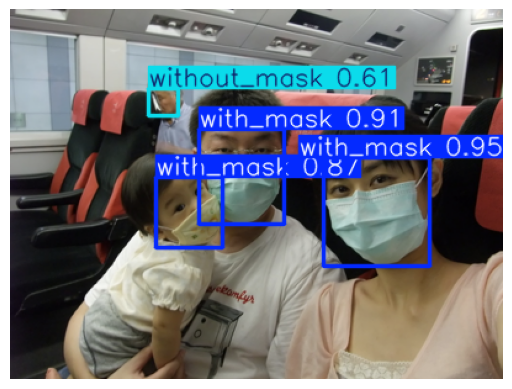

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

saved_model = YOLO("saved_models/mask_detector.pt")
sample_img = '/Users/jiveshkarthik/Documents/Visual Studio Code/Sem 7/Deep learning/DeepLearning- mini project/archive/images/maksssksksss7.png' # pick another sample
results = saved_model.predict(source=sample_img, conf=0.25, show=False)  # show=False for inline plotting

# Print detections
for box in results[0].boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = saved_model.names[cls_id]
    print(f"Detected: {label} with confidence {conf:.2f}")

# Save result
results[0].save(filename="output_from_saved_model.png")
print("Inference done using saved model. Output saved as output_from_saved_model.png")

plt.imshow(results[0].plot()[:, :, ::-1])  # convert BGR -> RGB
plt.axis("off")
plt.show()


In [ ]:
from ultralytics import YOLO
import cv2

# Load the trained YOLO model
model = YOLO("saved_models/mask_detector.pt")

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to read frame.")
        break
    results = model.predict(source=frame, conf=0.4, show=False)
    annotated_frame = results[0].plot()
    cv2.imshow("Live Mask Detection", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()



0: 256x416 (no detections), 35.7ms
Speed: 2.3ms preprocess, 35.7ms inference, 4.3ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.0ms
Speed: 0.9ms preprocess, 20.0ms inference, 4.0ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 19.8ms
Speed: 0.8ms preprocess, 19.8ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 18.6ms
Speed: 0.8ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 19.8ms
Speed: 0.8ms preprocess, 19.8ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.5ms
Speed: 0.8ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.5ms
Speed: 0.8ms preprocess, 20.5ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.5ms
Speed: 1.6ms preprocess, 20.5ms inferenc

2025-10-10 12:58:24.605 Python[67878:6163033] +[IMKClient subclass]: chose IMKClient_Modern
2025-10-10 12:58:24.605 Python[67878:6163033] +[IMKInputSession subclass]: chose IMKInputSession_Modern



0: 256x416 1 without_mask, 32.8ms
Speed: 1.0ms preprocess, 32.8ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 22.9ms
Speed: 0.9ms preprocess, 22.9ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.7ms
Speed: 0.9ms preprocess, 20.7ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 21.8ms
Speed: 0.9ms preprocess, 21.8ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 21.3ms
Speed: 0.9ms preprocess, 21.3ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 21.5ms
Speed: 0.8ms preprocess, 21.5ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 21.5ms
Speed: 1.3ms preprocess, 21.5ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 without_mask, 20.1ms
Speed: 1.0ms preprocess, 20.1ms inference